
<div class="alert alert-info">

**This is a fixed-text formatted version of a Jupyter notebook**

- Try online [![Binder](https://mybinder.org/badge.svg)](https://mybinder.org/v2/gh/gammapy/gammapy/v0.12?urlpath=lab/tree/hess.ipynb)
- You can contribute with your own notebooks in this
[GitHub repository](https://github.com/gammapy/gammapy/tree/master/tutorials).
- **Source files:**
[hess.ipynb](../_static/notebooks/hess.ipynb) |
[hess.py](../_static/notebooks/hess.py)
</div>


# H.E.S.S. with Gammapy

This tutorial explains how to analyse [H.E.S.S.](https://www.mpi-hd.mpg.de/hfm/HESS) data with Gammapy.

We will analyse four observation runs of the Crab nebula, which are part of the [H.E.S.S. first public test data release](https://www.mpi-hd.mpg.de/hfm/HESS/pages/dl3-dr1/). In this tutorial we will make an image and a spectrum. The [light_curve.ipynb](light_curve.ipynb) notbook contains an example how to make a light curve.

To do a 3D analysis, one needs to do a 3D background estimate. In [background_model.ipynb](background_model.ipynb) we have started to make a background model, and in this notebook we have a first look at a 3D analysis. But the results aren't OK yet, the background model needs to be improved. In this analysis, we also don't use the energy dispersion IRF yet, and we only analyse the data in the 1 TeV to 10 TeV range. The H.E.S.S. data was only released very recently, and 3D analysis in Gammapy is new. This tutorial will be improved soon.

This tutorial also shows how to do a classical image analysis using the ring bakground. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import numpy as np
from scipy.stats import norm
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion
from gammapy.data import DataStore
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.cube import MapMaker, MapDataset, PSFKernel, MapMakerRing
from gammapy.cube.models import SkyModel, BackgroundModel
from gammapy.spectrum.models import PowerLaw
from gammapy.spectrum import CrabSpectrum
from gammapy.image.models import SkyPointSource
from gammapy.detect import compute_lima_on_off_image
from gammapy.scripts import SpectrumAnalysisIACT
from gammapy.utils.fitting import Fit
from gammapy.background import RingBackgroundEstimator

## Data access

To access the data, we use the `DataStore`, and we use the ``obs_table`` to select the Crab runs.

In [3]:
data_store = DataStore.from_file(
    "$GAMMAPY_DATA/hess-dl3-dr1/hess-dl3-dr3-with-background.fits.gz"
)
mask = data_store.obs_table["TARGET_NAME"] == "Crab"
obs_table = data_store.obs_table[mask]
observations = data_store.get_observations(obs_table["OBS_ID"])

In [4]:
# pos_crab = SkyCoord.from_name('Crab')
pos_crab = SkyCoord(83.633, 22.014, unit="deg")

## Maps

Let's make some 3D cubes, as well as 2D images.

For the energy, we make 5 bins from 1 TeV to 10 TeV.

In [5]:
energy_axis = MapAxis.from_edges(
    np.logspace(0, 1.0, 5), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(83.633, 22.014),
    binsz=0.02,
    width=(5, 5),
    coordsys="CEL",
    proj="TAN",
    axes=[energy_axis],
)

In [6]:
%%time
maker = MapMaker(geom, offset_max="2.5 deg")
maps = maker.run(observations)
images = maker.run_images()

CPU times: user 6.54 s, sys: 386 ms, total: 6.92 s
Wall time: 3.94 s


In [7]:
maps.keys()

dict_keys(['counts', 'exposure', 'background'])

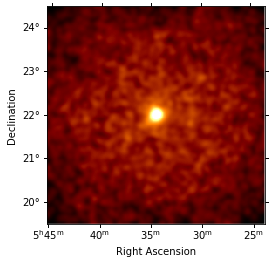

In [8]:
images["counts"].smooth(3).plot(stretch="sqrt", vmax=2);

## PSF

Compute the mean PSF for these observations at the Crab position.

In [9]:
from gammapy.irf import make_mean_psf

table_psf = make_mean_psf(observations, pos_crab)

In [10]:
psf_kernel = PSFKernel.from_table_psf(table_psf, geom, max_radius="0.3 deg")
psf_kernel_array = psf_kernel.psf_kernel_map.sum_over_axes().data
# psf_kernel.psf_kernel_map.slice_by_idx({'energy': 0}).plot()
# plt.imshow(psf_kernel_array)

## Map fit

Let's fit this source assuming a Gaussian spatial shape and a power-law spectral shape, and a background with a flexible normalisation

In [11]:
spatial_model = SkyPointSource(
    lon_0="83.6 deg", lat_0="22.0 deg", frame="icrs"
)
spectral_model = PowerLaw(
    index=2.6, amplitude="5e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
model = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model)
background_model = BackgroundModel(maps["background"], norm=1.0)
background_model.parameters["tilt"].frozen = False

In [12]:
%%time
dataset = MapDataset(
    model=model,
    counts=maps["counts"],
    exposure=maps["exposure"],
    background_model=background_model,
    psf=psf_kernel,
)
fit = Fit(dataset)
result = fit.run()
print(result)

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 275
	total stat : 61227.19

CPU times: user 4.46 s, sys: 37.7 ms, total: 4.5 s
Wall time: 2.26 s


Best fit parameters:

In [13]:
result.parameters.to_table()

<Table length=8>
   name     value      error        unit         min        max    frozen
   str9    float64    float64      str14       float64    float64   bool 
--------- ---------- --------- -------------- ---------- --------- ------
    lon_0  8.362e+01 2.978e-03            deg -1.800e+02 1.800e+02  False
    lat_0  2.202e+01 2.789e-03            deg -9.000e+01 9.000e+01  False
    index  2.634e+00 9.309e-02                       nan       nan  False
amplitude  4.992e-11 4.170e-12 cm-2 s-1 TeV-1        nan       nan  False
reference  1.000e+00 0.000e+00            TeV        nan       nan   True
     norm  2.920e+00 6.044e-02                 0.000e+00       nan  False
     tilt -1.992e-02 2.061e-02                       nan       nan  False
reference  1.000e+00 0.000e+00            TeV        nan       nan   True

Parameters covariance:

In [14]:
result.parameters.covariance_to_table()

<Table length=8>
   name     lon_0      lat_0      index    ... reference    norm       tilt   
   str9    float64    float64    float64   ...  float64   float64    float64  
--------- ---------- ---------- ---------- ... --------- ---------- ----------
    lon_0  8.869e-06 -3.310e-07  1.377e-06 ... 0.000e+00  1.786e-07 -5.766e-08
    lat_0 -3.310e-07  7.778e-06  7.157e-07 ... 0.000e+00 -3.872e-07 -6.663e-08
    index  1.377e-06  7.157e-07  8.665e-03 ... 0.000e+00 -2.040e-04 -8.831e-05
amplitude -2.480e-17  1.031e-16  3.102e-13 ... 0.000e+00 -1.315e-14 -3.561e-15
reference  0.000e+00  0.000e+00  0.000e+00 ... 0.000e+00  0.000e+00  0.000e+00
     norm  1.786e-07 -3.872e-07 -2.040e-04 ... 0.000e+00  3.653e-03  1.012e-03
     tilt -5.766e-08 -6.663e-08 -8.831e-05 ... 0.000e+00  1.012e-03  4.248e-04
reference  0.000e+00  0.000e+00  0.000e+00 ... 0.000e+00  0.000e+00  0.000e+00

## Residual image

We compute a residual image as `residual = counts - model`. Note that this is counts per pixel and our pixel size is 0.02 deg. Smoothing is counts-preserving. The residual image shows that currently both the source and the background modeling isn't very good. The background model is underestimated (so residual is positive), and the source model is overestimated.

In [15]:
npred = dataset.npred()
residual = Map.from_geom(maps["counts"].geom)
residual.data = maps["counts"].data - npred.data

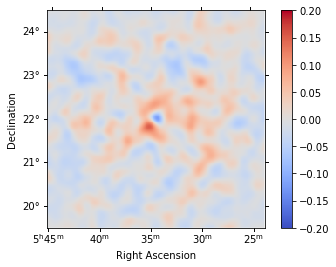

In [16]:
residual.sum_over_axes().smooth("0.1 deg").plot(
    cmap="coolwarm", vmin=-0.2, vmax=0.2, add_cbar=True
);

## Spectrum

We could try to improve the background modeling and spatial model of the source. But let's instead turn to one of the classic IACT analysis techniques: use a circular on region and reflected regions for background estimation, and derive a spectrum for the source without having to assume a spatial model, or without needing a 3D background model.

In [17]:
%%time
on_region = CircleSkyRegion(pos_crab, 0.11 * u.deg)
exclusion_mask = Map.from_geom(geom.to_image())
exclusion_mask.data = np.ones_like(exclusion_mask.data, dtype=bool)

model_pwl = PowerLaw(
    index=2.6, amplitude="5e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)

config = {
    "outdir": ".",
    "background": {"on_region": on_region, "exclusion_mask": exclusion_mask},
    "extraction": {"containment_correction": True},
    "fit": {"model": model_pwl, "fit_range": [1, 10] * u.TeV},
    "fp_binning": np.logspace(0, 1, 11) * u.TeV,
}
analysis = SpectrumAnalysisIACT(observations=observations, config=config)
analysis.run()

/Users/adonath/github/adonath/gammapy/gammapy/spectrum/extract.py:232: RuntimeWarning: invalid value encountered in true_divide
  self.containment = new_aeff.data.data.value / self._aeff.data.data.value


CPU times: user 4.92 s, sys: 60 ms, total: 4.98 s
Wall time: 3.91 s


In [18]:
print(model_pwl)

PowerLaw

Parameters: 

	   name     value     error        unit      min max frozen
	--------- --------- --------- -------------- --- --- ------
	    index 2.578e+00 1.135e-01                nan nan  False
	amplitude 4.412e-11 4.060e-12 cm-2 s-1 TeV-1 nan nan  False
	reference 1.000e+00 0.000e+00            TeV nan nan   True

Covariance: 

	   name     index   amplitude reference
	--------- --------- --------- ---------
	    index 1.288e-02 3.562e-13 0.000e+00
	amplitude 3.562e-13 1.648e-23 0.000e+00
	reference 0.000e+00 0.000e+00 0.000e+00


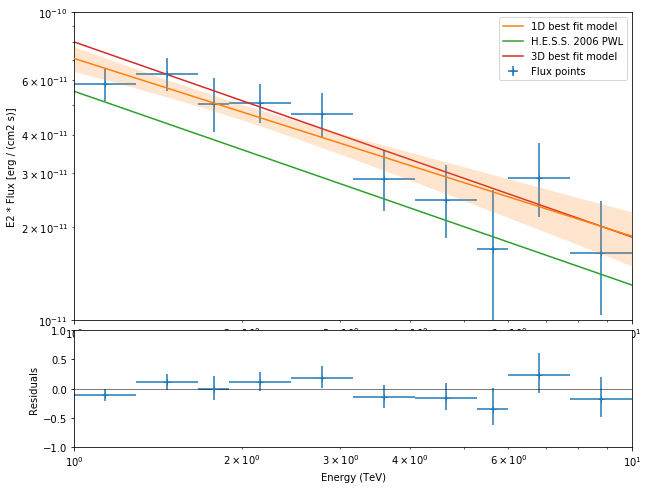

In [19]:
plt.figure(figsize=(10, 8))
crab_ref = CrabSpectrum("hess_pl").model

dataset_fp = analysis.spectrum_result

plot_kwargs = {
    "energy_range": [1, 10] * u.TeV,
    "flux_unit": "erg-1 cm-2 s-1",
    "energy_power": 2,
}

model_kwargs = {"label": "1D best fit model"}
model_kwargs.update(plot_kwargs)
ax_spectrum, ax_residuals = dataset_fp.peek(model_kwargs=model_kwargs)

crab_ref.plot(ax=ax_spectrum, label="H.E.S.S. 2006 PWL", **plot_kwargs)
model.spectral_model.plot(
    ax=ax_spectrum, label="3D best fit model", **plot_kwargs
)

ax_spectrum.set_ylim(1e-11, 1e-10)
ax_spectrum.legend();

## Classical Ring Background Analysis

In this section, we do a classical ring background analysis on the MSH 15-52 region. Let us first select these runs in the datastore

In [20]:
data_store = DataStore.from_file(
    "$GAMMAPY_DATA/hess-dl3-dr1/hess-dl3-dr3-with-background.fits.gz"
)
data_sel = data_store.obs_table["TARGET_NAME"] == "MSH 15-52"
obs_table = data_store.obs_table[data_sel]
observations = data_store.get_observations(obs_table["OBS_ID"])

In [21]:
# pos_msh1552 = SkyCoord.from_name('MSH15-52')
pos_msh1552 = SkyCoord(228.32, -59.08, unit="deg")

We first have to define the geometry on which we make our 2D map.

In [22]:
energy_axis = MapAxis.from_edges(
    np.logspace(0, 5.0, 5), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=pos_msh1552,
    binsz=0.02,
    width=(5, 5),
    coordsys="CEL",
    proj="TAN",
    axes=[energy_axis],
)

### Choose an exclusion mask.
We choose an exclusion mask on the position of MSH 1552. 

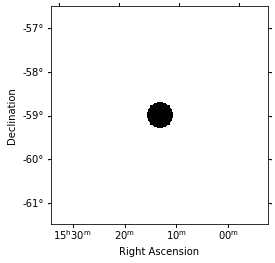

In [23]:
regions = CircleSkyRegion(center=pos_msh1552, radius=0.3 * u.deg)
mask = Map.from_geom(geom)
mask.data = mask.geom.region_mask([regions], inside=False)
mask.get_image_by_idx([0]).plot();

Now, we instantiate the ring background

In [24]:
ring_bkg = RingBackgroundEstimator(r_in="0.5 deg", width="0.3 deg")

To facilitate classical image analysis, we have a special class called `MapMakerRing`. Here, we do the analysis over the integrated energy range. To do an analysis for each image slice of the map (eg: to investigate the significance of the source detection with energy, just call `run` instead of `run_images`

In [25]:
%%time
im = MapMakerRing(
    geom=geom,
    offset_max=2.0 * u.deg,
    exclusion_mask=mask,
    background_estimator=ring_bkg,
)
images = im.run_images(observations)

CPU times: user 11.7 s, sys: 511 ms, total: 12.2 s
Wall time: 6.18 s


We will use `compute_lima_on_off_image` in `gammapy.detect` to compute significance and excess maps. A common debug plot during Ring Analysis is to make histograms of the `off` count rates, so we will plot that as well.

For this we will first create a Tophat2DKernel convolution kernel for the significance maps. To convert from angles to pixel scales, we use `geom.pixel_scales`:

In [26]:
scale = geom.pixel_scales[0].to("deg")
# Using a convolution radius of 0.05 degrees
theta = 0.05 * u.deg / scale
tophat = Tophat2DKernel(theta)
tophat.normalize("peak")

In [27]:
lima_maps = compute_lima_on_off_image(
    images["on"],
    images["off"],
    images["exposure_on"],
    images["exposure_off"],
    tophat,
)

In [28]:
significance_map = lima_maps["significance"]
excess_map = lima_maps["excess"]

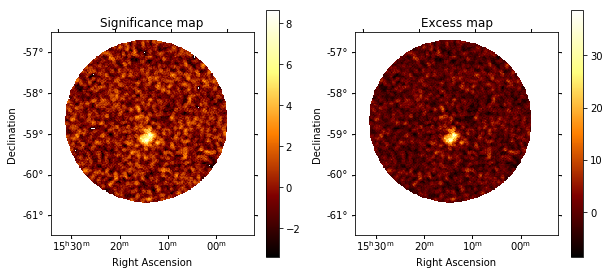

In [29]:
plt.figure(figsize=(10, 10))
ax1 = plt.subplot(221, projection=significance_map.geom.wcs)
ax2 = plt.subplot(222, projection=excess_map.geom.wcs)

ax1.set_title("Significance map")
significance_map.plot(ax=ax1, add_cbar=True)

ax2.set_title("Excess map")
excess_map.plot(ax=ax2, add_cbar=True);

In [30]:
# create a 2D mask for the images
image_mask = mask.slice_by_idx({"energy": 0})
significance_map_off = significance_map * image_mask

Fit results: mu = -0.07, std = 1.03


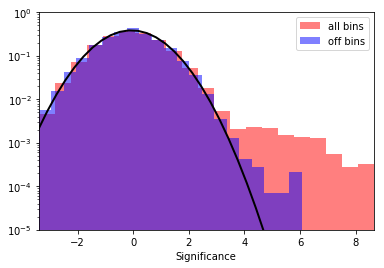

In [31]:
significance_all = significance_map.data[np.isfinite(significance_map.data)]
significance_off = significance_map_off.data[
    np.isfinite(significance_map_off.data)
]

plt.hist(
    significance_all,
    density=True,
    alpha=0.5,
    color="red",
    label="all bins",
    bins=21,
)

plt.hist(
    significance_off,
    density=True,
    alpha=0.5,
    color="blue",
    label="off bins",
    bins=21,
)

# Now, fit the off distribution with a Gaussian
mu, std = norm.fit(significance_off)
x = np.linspace(-8, 8, 50)
p = norm.pdf(x, mu, std)
plt.plot(x, p, lw=2, color="black")
plt.legend()
plt.xlabel("Significance")
plt.yscale("log")
plt.ylim(1e-5, 1)
xmin, xmax = np.min(significance_all), np.max(significance_all)
plt.xlim(xmin, xmax)

print("Fit results: mu = {:.2f}, std = {:.2f}".format(mu, std))

The significance and excess maps clearly indicate a bright source at the position of MSH 1552. This is also evident from the significance distribution. The off distribution should ideally be a Gaussian with `mu=0`, `sigma=1`

In [32]:
print(
    "Excess from entire map: {:.1f}".format(
        np.nansum(lima_maps["excess"].data)
    )
)
print(
    "Excess from off regions: {:.1f}".format(
        np.nansum((lima_maps["excess"] * image_mask).data)
    )
)

Excess from entire map: 4896.4
Excess from off regions: -1030.4


Again: please note that this tutorial notebook was put together quickly, the results obtained here are very preliminary. We will work on Gammapy and the analysis of data from the H.E.S.S. test release and update this tutorial soon.

## Exercises

- Try analysing another source, e.g. RX J1713.7−3946
- Try another model, e.g. a Gaussian spatial shape or exponential cutoff power-law spectrum.